In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import scipy.optimize as sc
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from main import get_portfolio

In [2]:
RFR = 0.00

In [3]:
def get_owned():
    port = get_portfolio()
    owned = list(port[0].index)
    faulty = ['KCS','CHSB','LTO','LYXe','REN','FORTH','RFUEL','REVV','USDT', 'USD', 'NMR','STMX']
    rename = {'ATOM': 'ATOM1', 'DOT': 'DOT1', 'GRT': 'GRT2', 'ONE': 'ONE2', 'SOL': 'SOL1'}
    owned = [ticker for ticker in owned if ticker not in faulty]
    owned = sorted([ticker+'-USD' if ticker not in rename.keys() else rename[ticker]+'-USD' for ticker in owned])
    return owned

def get_data(assets, start, end, log):
    asset_data = yf.download(assets, start=start, end=end)
    asset_data = asset_data['Adj Close']
    delta_days = len(asset_data)
    if log:
        returns = np.log(asset_data / asset_data.shift(1))    
    else:
        returns = asset_data.pct_change()                    
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return mean_returns, cov_matrix, delta_days

def port_performance(weights, mean_returns, cov_matrix, delta_days):
    expected_returns = np.sum(mean_returns * weights) * delta_days
    expected_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(delta_days)
    return expected_returns, expected_volatility

def port_returns(weights, mean_returns, cov_matrix, delta_days, negative):
    if negative:
        return -1 * port_performance(weights, mean_returns, cov_matrix, delta_days)[0]
    else:
        return port_performance(weights, mean_returns, cov_matrix, delta_days)[0]

def port_volatility(weights, mean_returns, cov_matrix, delta_days):
    return port_performance(weights, mean_returns, cov_matrix, delta_days)[1]

def negative_sharpe(weights, mean_returns, cov_matrix, delta_days, rfr=RFR):
    expected_returns, expected_volatility = port_performance(weights, mean_returns, cov_matrix, delta_days)
    sharpe_ratio = (expected_returns - rfr) / expected_volatility
    neg_sharpe = -1 * sharpe_ratio
    return neg_sharpe

def maximize_returns(mean_returns, cov_matrix, delta_days, bound=(0,1)):
    num_assets = len(mean_returns)
    initial_weights = num_assets * [1.0 / num_assets]
    arguments = (mean_returns, cov_matrix, delta_days, True)
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    result = sc.minimize(port_returns, initial_weights, method='SLSQP', args=arguments, bounds=bounds, constraints=constraints)
    return result

def minimize_volatility(mean_returns, cov_matrix, delta_days, bound=(0,1)):
    num_assets = len(mean_returns)
    initial_weights = num_assets * [1.0 / num_assets]
    arguments = (mean_returns, cov_matrix, delta_days)
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    result = sc.minimize(port_volatility, initial_weights, method='SLSQP', args=arguments, bounds=bounds, constraints=constraints)
    return result

def maximize_sharpe(mean_returns, cov_matrix, delta_days, bound=(0,1)):
    num_assets = len(mean_returns)
    initial_weights = num_assets * [1.0 / num_assets]
    arguments = (mean_returns, cov_matrix, delta_days)
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    result = sc.minimize(negative_sharpe, initial_weights, method='SLSQP', args=arguments, bounds=bounds, constraints=constraints)
    return result

def simulate_portfolios(mean_returns, cov_matrix, delta_days):
    num_ports = 10000
    sharpe_ratios = np.zeros(num_ports)
    exp_returns = np.zeros(num_ports)
    exp_vols = np.zeros(num_ports)
    weights = np.zeros((num_ports, len(mean_returns)))

    for k in range(num_ports):
        w = np.array(np.random.random(len(mean_returns)))
        weights[k] = w / np.sum(w)
        exp_returns[k], exp_vols[k] = port_performance(weights[k], mean_returns, cov_matrix, delta_days)
        sharpe_ratios[k] = exp_returns[k] / exp_vols[k]
    return exp_returns, exp_vols, sharpe_ratios, weights

def efficient_frontier(mean_returns, cov_matrix, delta_days, return_target, bound=(0,1)):
    num_assets = len(mean_returns)
    initial_w = num_assets * [1.0 / num_assets]
    arguments = (mean_returns, cov_matrix, delta_days)
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: port_returns(w, mean_returns, cov_matrix, delta_days, negative=False) - return_target})
    opt = sc.minimize(port_volatility, initial_w, method='SLSQP', args=arguments, bounds=bounds, constraints=constraints)
    return opt['fun']

def get_results(mean_returns, cov_matrix, delta_days):
    max_rets_port = maximize_returns(mean_returns, cov_matrix, delta_days)['x']
    max_rets_returns, max_rets_vol = port_performance(max_rets_port, mean_returns, cov_matrix, delta_days)

    min_vol_port = minimize_volatility(mean_returns, cov_matrix, delta_days)['x']
    min_vol_returns, min_vol_vol = port_performance(min_vol_port, mean_returns, cov_matrix, delta_days)

    max_sharpe_port = maximize_sharpe(mean_returns, cov_matrix, delta_days)['x']
    max_sharpe_returns, max_sharpe_vol = port_performance(max_sharpe_port, mean_returns, cov_matrix, delta_days)

    frontier_list = []
    target_returns = np.linspace(min_vol_returns, max_rets_returns, 50)
    for return_target in target_returns:
        frontier_list.append(efficient_frontier(mean_returns, cov_matrix, delta_days, return_target))


    max_rets_perf = (max_rets_returns, max_rets_vol, [round(i * 100, 3) for i in max_rets_port])
    min_vol_perf = (min_vol_returns, min_vol_vol, [round(i * 100, 3) for i in min_vol_port])
    max_sharpe_perf = (max_sharpe_returns, max_sharpe_vol, [round(i * 100, 3) for i in max_sharpe_port])

    return max_rets_perf, min_vol_perf, max_sharpe_perf, frontier_list, target_returns

def plot_results(mean_returns, cov_matrix, delta_days, assets):
    max_rets_perf, min_vol_perf, max_sharpe_perf, frontier_list, target_returns = get_results(mean_returns, cov_matrix, delta_days)
    sim_returns, sim_vols, sim_sharpe, weights = simulate_portfolios(mean_returns, cov_matrix, delta_days)
    sim_max_index = sim_sharpe.argmax()

    max_rets_w = max_rets_perf[2]
    max_rets_weights = [{ticker.split('-')[0]:round(x, 1)} for ticker, x in zip(assets, max_rets_w)]

    min_vol_w = min_vol_perf[2]
    min_vol_weights = [{ticker.split('-')[0]:round(x, 1)} for ticker, x in zip(assets, min_vol_w)]

    max_sharpe_w = max_sharpe_perf[2]
    max_sharpe_weights = [{ticker.split('-')[0]:round(x, 1)} for ticker, x in zip(assets, max_sharpe_w)]

    sim_max_sharpe_w = weights[sim_max_index]
    sim_max_sharpe_w = [round(i * 100, 3) for i in sim_max_sharpe_w]
    sim_max_sharpe_weights = [{ticker.split('-')[0]:round(x, 1)} for ticker, x in zip(assets, sim_max_sharpe_w)]

    font1 = {'family':'serif','color':'blue','size':20}
    font2 = {'family':'serif','color':'darkred','size':15}

    plt.figure(figsize=(20, 6))
    plt.scatter(sim_vols, sim_returns, c=sim_sharpe)
    plt.title("Efficient Frontier", fontdict=font1)
    plt.xlabel("Expected Volatility", fontdict=font2)
    plt.ylabel("Expected Returns", fontdict=font2)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.colorbar(label="SR")
    plt.scatter(max_rets_perf[1], max_rets_perf[0], c="blue", marker="*", s=200, label=f"Max Returns: {max_rets_weights}")
    plt.scatter(min_vol_perf[1], min_vol_perf[0], c="magenta", marker="*", s=200, label=f"Min Volatility: {min_vol_weights}")
    plt.scatter(sim_vols[sim_max_index], sim_returns[sim_max_index], c="red", s=50, label=f"Sim Max SR: {sim_max_sharpe_weights}")
    plt.scatter(max_sharpe_perf[1], max_sharpe_perf[0], c="orange", s=50, label=f"Opt Max SR: {max_sharpe_weights}")
    plt.plot(frontier_list, target_returns, label="Frontier")
    plt.legend()
    plt.show()

In [4]:
# assets = get_owned()

In [5]:
# assets = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'SOL1-USD']

assets = ['CEVA', 'GOOGL', 'TSLA', 'ZOM']

# end_date = dt.datetime.now()
# start_date = end_date - dt.timedelta(days=30)

start_date = dt.date(2021, 1, 1)
end_date = dt.date(2021, 1, 23)

mean_returns, cov_matrix, delta_days = get_data(assets, start_date, end_date, log=False)

[*********************100%***********************]  4 of 4 completed


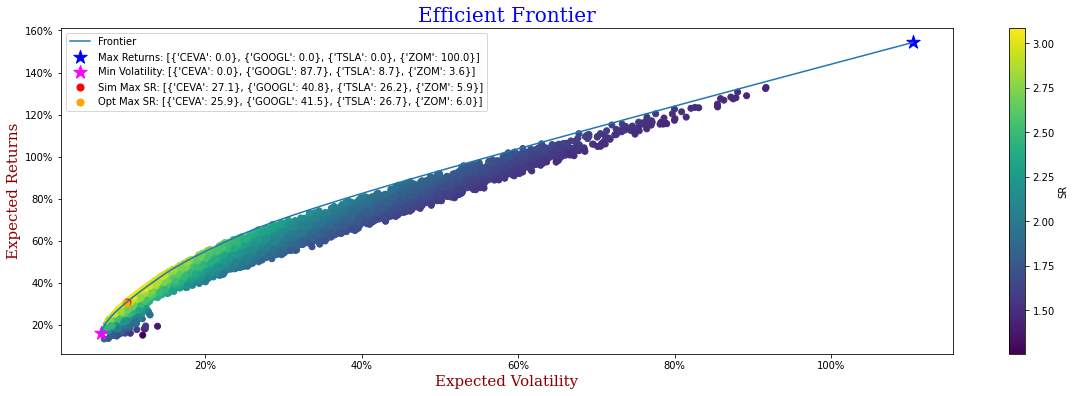

In [6]:
plot_results(mean_returns, cov_matrix, delta_days, assets)

In [7]:
# result = maximize_sharpe(mean_returns, cov_matrix, delta_days)
# vector = result['x']
# optimal_weights = [{ticker.split('-')[0]:round(x, 3)} for ticker,x in zip(assets,vector)]
# list(optimal_weights[0].values())[0] > 0
# final = [d for d in optimal_weights if list(d.values())[0] > 0] 
# print(final)